In [88]:
### PREAMBLE
# Intro to machine learning
# scatter_fit_title.svg

import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Introduction

This lecture transition to the next unit in this course.  Whereas the previous lectures have largely been about data processing (how we obtain, store, and operate upon different types of data you're likely to encounter in data science tasks), this lecture will mark a shift to the question of analysis: how do we make predictions about and analyze the data we have collected?  We have already seen a little bit of this in the context of free text processing, but this lecture will shift even more to this question, starting with the topic of machine learning.

Machine learning is a fast-growing field at the current time, though we should emphasize that the initial techniques we're going to cover here (namely linear regression) pre-date the term by about 200 years (Gauss is typically credited for developing least squares regression in around 1800).  And much of the later techniques we talk about were well-studied in statistics in the early part of the century.  We're still going to use the general term machine learning to cover all these, but it is important to know that these ideas did not start with the ML community.  Rather, machine learning as a topic has grown due to the combination of three different elements: 1) gains in computing power (machine learning, as it grew out of computer science, has always been fundamentally concerned with computational algorithms), 2) massive amounts of available data (the "raw materials" for machine learning methods), and 3) some notable algorithmic advances that have occurred over the last 30 years.  To start, though, we're going to cover some of the most basic algorithms to codify the underlying principles.

## Introduction to machine learning

Machine learning, at its core, is a data driven way to write program.  Let's
say (and this isn't entirely hypothetical, as this task is now so common a benchmark in machine learning that it has become passe), you want to write a program that can
classify one of following images as a digit between 0 and 9:

![Images of digits from the MNIST dataset, a benchmark machine learning task.](digits.png)

The "traditional" way of writing a program like this is to think logically about
what short of distinguishing characteristics make up each digit, codify this
logic as a computer program, and then write it down (probably iterating as
necessary when you find that your logic didn't work for some cases).  This
general programming technique (if you could even call it that, as it is
typically just part of what we think about when we think of writing comptuer
programs) has proven extremely useful in many situations, but it also can prove
exceptionally difficult in some cases, including the image case above.  The idea
of identifying digits seems "easy" to us, but for a computer program, these
images are just 28x28 collections of pixels, and writing code that can express
high-level concepts like the general "shape" of a character is quite challenge.

The machine learning approach to a problem like this, in contrast, is the
following.  Instead of attempting to manually construct a program that produces
image classifications from pixels, we collect a \emph{data set} that consists of
a large number of images and their corresponding labels, then use a machine
learning algorithm to _automatically_ learn a kind of "program" that can produce
these correct classifications on the data set that we have.  We use the term
"program" here because, although the resulting classifier is not what we typically think
of as a program (ML "programs" usually consist of simple parameterized functions of a
particular form) it conceptually acts in the same manner. Strictly
speaking, the process described here (where we provide the algorithm both the
inputs and the target labels) is actually a subclass of machine learning
known as "supervised learning", but the same ideas we introduce below actually
also apply surprisngly similarly to the so-called unsupervised learning setting,
which we will discuss later.

### Example: predicting peak electrical power

Let's consider the above problem a bit more formally, staring with a simple
example.  Suppose you want to predict what the peak electricity demand will be
during the day tomorrow for some area (we'll consider data from the area
surrounding Pittsburgh, PA).  This is actually a very important problem from a
logitics planning perspective: electricity generators, which for the most part
are based upon boiling water to move turbines, cannot turn on instantly, so in
order to guarantee that we have enough power to supply a given area, a system
operator typically needs to have some excess generation always waiting in the
wings.  The better we can forecast future demand, the smaller our excess margin
can be, leading to increased efficiency of the entire electrical grid.  
The power consumption tomorrow depends on many factors: temperature, day of
week, season, holiday events, etc, not to mention some inherrent randomness
that we don't expect to even predict with perfect accuracy.  However, even for
someone working in the area, it would be very
difficult to come up with a model for electrical demand based soley upon "first
principles", thinking about the nature of electricity consumption or the devices
people may use, in an attempt to predict future consumption.

What _is_ easy, however, is simply to collect lots of data about past energy
consumption (the system operator serving the Pittsburgh region, PJM, maintains
a data set available [here](http://www.pjm.com/markets-and-operations/ops-analysis/historical-load-data.aspx)) 
as well as the past factors that affect consumption, like the past weather for
the area (which can be easily downloaded from the [WeFacts](http://wefacts.org) site we mentioned earlier).  Since this is a data science course, and since we've already covered the data collection process, let's be very explicit, and show the data collection process.  Specifically, we downloaded the `201X-hourly-loads.xls` files for 2013-2017, and the weather for Pittsburgh from 2013-2017 (in the `kpit_weather.csv` file).  The files we are loading are the raw files we downloaded from these two sites, with no preprocessing.  We can load and plot the data with the following code.

In [77]:
import pandas as pd
import glob

In [78]:
# load electrical demand data
df_load = pd.concat([pd.read_excel(filename, sheetname="DUQ")[["DATE", "MAX"]]
                        for filename in glob.glob("*-hourly-loads.xls")], 
                    ignore_index=True)

# load weather and get maximum by day
df_weather = pd.read_csv("kpit_weather.csv")
df_weather = df_weather[df_weather["Time"] != -9999]
df_weather["Date"] = df_weather["Time"].apply(lambda x: str(x)[:8])
df = df_weather.groupby("Date").max()[["OAT"]]
df["Temp"] = df["OAT"].apply(lambda x : x/10. * (9/5) + 32)

# join with load, then get just summer methods
df["Load"] = pd.Series(df_load["MAX"].values/1000, index=df.index)
df_summer = df[list(map(lambda x : x[4:6] in ["06", "07", "08"], df.index))]

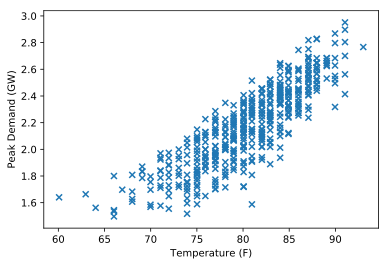

In [79]:
plt.scatter(df_summer["Temp"], df_summer["Load"], marker='x')
plt.xlabel("Temperature (F)")
plt.ylabel("Peak Demand (GW)")

As it turns out, electricity consumption in the summer in Pittsburgh is largely
driven by air conditioning, so with increasing high temperature comes increasing
electrical demand.  Thus, we may hypothesize that we can form a fairly good prediction of the peak demand using a linear model: that is, we hypothesize that 
\begin{equation}
\mathrm{PeakDemand} \approx \theta_1 \cdot \mathrm{HighTemperature} + \theta_2
\end{equation}
where $\theta_1$ is the slope of the line and $\theta_2$ is the intercept term (together called the _parameters_ of the model).  For example, just eyeballing the data we might guess that the slope is $\theta_1 = 0.05$ (we get an increase of 0.05 GW per degree F, which we just arrived at by seeing that the power increased, very apprximately, by noticing a total of ~1 GW increase in the range of 70 to 90 degree).  If we further suppose that the average demand is about 2.1GW at 80 degrees F, then we can solve for the intercept term by $0.05*80 + \theta_2 = 2.1$, or $\theta_2 = -1.9$.  Note: if this seems ad-hoc to you, don't worry, it is!  We will shortly decribe to to actually find good values for these parameters in a disciplined way.

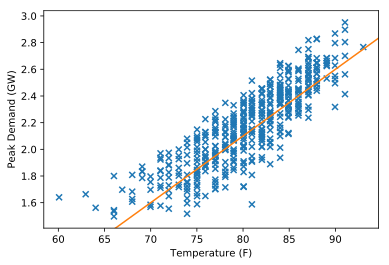

In [104]:
theta = np.array([0.05, -1.9])
plt.scatter(df_summer["Temp"], df_summer["Load"], marker='x')
xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.plot(xlim, [theta[0]*xlim[0]+theta[1], theta[0]*xlim[1]+theta[1]], 'C1')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("Temperature (F)")
plt.ylabel("Peak Demand (GW)")

Naturally, this model won't fit the data exactly (we can see from the
chart that the figure doesn't lie precisely on an exact line), but if we can
find slope and intercept terms that fit the data well, then for example, if we
want to know what the peak demand will be tomorrow we can simply plug in the
forecasted high temperature into the equation above get an estimate of the peak
demand tomorrow (ignore the fact, for now
that the high temperature tomorrow is also a prediction, we'll assume we just
get this from a reliable source, and domains like weather forecasting are
extremely well-studied in practice).  This is of course equivalent to just "finding a point on the line".

### Finding good parameters

The question, of course, is how we find "good" values for $\theta_1$ and $\theta_2$ that fit this data well, i.e., so that the line fits the data as "closely" as possible.  The method we will describe for doing this (which is called _gradient descent_) is probably not the simplest algorithm for finding this fit.  In fact, as we will see, there is a very simple closed-form expression that will immediately give us the same solution for the framework we consider here.  But gradient descent is an _extremely_ powerful and general algorithm (and _is_ actually quite simple compared to some alternative approaches), and it is no exaggeration to say that gradient descent underlies virtually all modern machine learning.  So, with these caveats in place, let's dive in to understanding how we find "good" parameters $\theta_1$ and $\theta_2$ in some disciplined manner.

**Objective functions**  In order to find good values for the parameters, we need to formally define what "good" means in this setting.  This will actually be one of the key questions for machine learning algorithms in general, and difference notions of goodness lead to different algorithms.  Fortunately, there are some very well-studied definitions in this context, and so we have some "standard" options that we can try.  The notion that we will consider here captures the idea of the "squared error" between the prediction and the actual values.  That is, we consider all the days in the plot above, where $\mathrm{HighTemperature}^{(i)}$ denotes the high temperature and $\mathrm{PeakDemand}^{(i)}$ denotes the peak demand on day $i$.  Since _predicted_ peak demand for day $i$ is equal to
\begin{equation}
\theta_1 \cdot \mathrm{HighTemperature} + \theta_2
\end{equation}
we want to make this quantity as close as possible, averaged over all the days, to the true $\mathrm{PeakDemand}^{(i)}$.  We're going to measure this closeness in terms of the squared difference between the predicted and actual more.  More formally, we would like to minimize the quantity:
\begin{equation}
\frac{1}{\# \mathrm{days}} \sum_{i \in \mathrm{days}} \left ( \theta_1 \cdot \mathrm{HighTemperature}^{(i)} + \theta_2 - \mathrm{PeakDemand}^{(i)} \right )^2 \equiv E(\theta)
\end{equation}
which we abbreviate as $E(\theta)$ to emphasize the fact that we are going to be minimizing this error by tuning our $\theta$ variables.  This is known as the _objective function_ that we are trying to minimize.  A natural question that you may be asking is: why did we choose to measure closeness using this squared difference?  Why not use the average of absolute difference?  Or the maximum absolute difference?  These are good questions, and we'll defer answering them for now, except to say that we will definitely consider other possibilities later.  The squared error is simply a very common choice, mainly for reasons of mathematical convenience.

**Minimizing the objective** How do we go about finding the values of $\theta_1$ and $\theta_2$ that minimize $E(\theta)$?  There are several ways to do this, but we'll consider one here based upon the notion of derivatives from calculus.  Recall that for a scalar function $f : \mathbb{R} \rightarrow \mathbb{R}$, the derivative of the function, denoted $f'$ provides the _slope_ of the function at any point).
![Illustration of a function and it's derivative.](opt_grad.svg)
In this figure, for regions on the left of the plot, the slope is negative, while on the right of the plot, the slope is positive.  Thus, if we want to minimize the function, and we begin at some point $\theta^{(0)}$, it makes sense to update this point by modifying it in the direction of the _negative_ dervative.  This simple intuition for the basis for the gradient descent algorithm.

**Note: Partial derivatives** As mentioned above, for scalar functions $f : \mathbb{R} \rightarrow \mathbb{R}$, we denote the derivative as $f'$ (also a scalar function $f' : \mathbb{R} \rightarrow \mathbb{R}$.  However, for vector-input functions, this notation becomes imprecise: it is not clear _which_ of the various derivatives we are taking.  For this reason, when we discuss derivatives of functions that take vectors as inputs, we use the notation of _partial_ derviatives.  The partial derivative of a function $f: \mathbb{R}^n \rightarrow \mathbb{R}$ with respect to the $j$th coordinate of the input vector, denoted
\begin{equation}
\frac{\partial f(\theta)}{\partial \theta_j}
\end{equation}
is just the derivative of $f$ with respect to $\theta_j$, _treating all other coordinates at constants_.  So for example for the function $f : \mathbb{R}^2 \rightarrow \mathbb{R}$
\begin{equation}
f(\theta) = \theta_1 \cdot \theta_2 + 3 \theta_1 - \theta_2
\end{equation}
then the partial derivatives are given by
\begin{equation}
\begin{split}
\frac{\partial f(\theta)}{\partial \theta_1} & = \theta_2 + 3 \\
\frac{\partial f(\theta)}{\partial \theta_2} & = \theta_1 - 1
\end{split}
\end{equation}
which is simply the derivative with respect to each of $\theta_1$ and $\theta_2$, treating the other term as a constant value.

### The gradient descent algorithm (first pass)

Extending our intuition above, the gradient descent algorithm for multivariate functions is intuitively just as simple as in the scalar case: we simply repeatedly take small steps in the derivative of the _negative partial derivatives_, for _each coordinate of our parameters_.  To see what this looks like, let's compute the partial derivatives with respect to $E(\theta)$ (our sum of squared error), with respect to $\theta_1$ and $\theta_2$.  The _only_ properties we will use here are:

1. Basic facts about the derivative of polynomials, i.e., that for $f(x) = x^2$, $f'(x) = 2x$.
2. The chain rule, that for $h(x) = f(g(x))$, $h'(x) = f'(g(x))g'(x)$
3. Linearity of the derivative, the fact that for $f(x) = \sum_i f_i(x)$, $f'(x) = \sum_i f_i'(x)$


In fact, other than the fact that the notation gets trickier when you have matrices and vectors, these are just about the only rules you need to derive most modern machine learning algorithms.  Let's also standardize our notation a bit by refering to $\mathrm{HighTemperature}^{(i)}$ just as $x^{(i)} \in \mathbb{R}$ (the $x$ notation comes from the fact that these are the "inputs" to our prediction model), and $\mathrm{PeakDemand}^{(i)}$ as $y^{(i)} \in \mathbb{R}$ (similarly, $y$ denoting the fact that this is the "output" of our prediction model).  We will also index each day as a number between 1 and $m$, where here $m$ will represent the total number of days.  Thus, we can rewrite our optimization objective as
\begin{equation}
E(\theta) = \frac{1}{m} \sum_{i=1}^m \left ( \theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right )^2.
\end{equation}
Let's compute the partial derivatives of this function with respect to $\theta_1$
\begin{equation}
\begin{split}
\frac{\partial E(\theta)}{\partial \theta_1} & = \frac{\partial}{\partial \theta_1} \frac{1}{m} \sum_{i=1}^m \left ( \theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right )^2 \\
& = \frac{1}{m} \sum_{i=1}^m \frac{\partial}{\partial \theta_1} \left ( \theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right )^2 \\
& = \frac{1}{m} \sum_{i=1}^m  2 \left ( \theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right ) \frac{\partial}{\partial \theta_1} \left (\theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right )  \\
& = \frac{1}{m} \sum_{i=1}^m  2 \left ( \theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right ) x^{(i)}
\end{split}
\end{equation}
where in the second line we use the linearity of the derivative, in the third line we use the chain rule and the above fact about differentating a polynomial, and in the fourth line we use the fact that all the terms except $\theta_1 \cdot x^{(i)}$ are "constants" in terms of differentiating with respect to $\theta_1$.  Using the exact same logic, we can also compute the partial derivative with respect to $\theta_2$
\begin{equation}
\begin{split}
\frac{\partial E(\theta)}{\partial \theta_2} & = \frac{\partial}{\partial \theta_2} \frac{1}{m} \sum_{i=1}^m \left ( \theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right )^2 \\
& = \frac{1}{m} \sum_{i=1}^m \frac{\partial}{\partial \theta_2} \left ( \theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right )^2 \\
& = \frac{1}{m} \sum_{i=1}^m  2 \left ( \theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right ) \frac{\partial}{\partial \theta_2} \left (\theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right )  \\
& = \frac{1}{m} \sum_{i=1}^m  2 \left ( \theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right )
\end{split}
\end{equation}
where all the derivatives proceed identically except for the fact that the coefficient term multiplying $\theta_2$ in the last equation is always equal to 1, so the equation has no $x^{(i)}$ term on the outside.  This leads to the gradient descent step for our setting, where we initialize $\theta_1$ and $\theta_2$ to some value (usually simply zero), and repeat the updates:
\begin{equation}
\begin{split}
\theta_1 & := \theta_1 - \frac{\alpha}{m} \sum_{i=1}^m  2 \left ( \theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right ) x^{(i)} \\
\theta_2 & := \theta_2 - \frac{\alpha}{m} \sum_{i=1}^m  2 \left ( \theta_1 \cdot x^{(i)} + \theta_2 - y^{(i)} \right ) \\
\end{split}
\end{equation}
where $\alpha$ is some small positive constant (indicating how big of a step in the direction of the negative gradient we take), called the _step size_.  We'll discuss the step size more shortly.  Note that we can also remove the "2" constant as this can just be incorporated into the step size.

**Data normalization**  We'll shortly see what the gradient descent procedure looks like in our example above.  Before we apply the algorithm, though, we're going to make one small modification to our problem, and _normalize_ the data (both the inputs and the output) before we attempt to run the gradient descent algorithm.  We will see the reason for this more clearly shortly, but the brief reason is that if our slope and intercept terms are on very different "scales" (which would be the case here, because of the relatively large input values (units of degrees Farenheit) compared to the output values (units of gigawatts)), then we would actually need to take very different step sizes in the two parameters $\theta_1$ and $\theta_2$.  This is possible to manually tune in our case, but when we start having many more parameters, it's not feasible.  We thus make our life much easier if we scale all the input and output data to be in the same rough range _before_ running gradient descent (Note: in class I talked about only scaling the input, which also happens to work fine here, but I think it may be easier conceptually to consider the case where we just normalize all the inputs and outputs in the same manner).

We can normalize data in a number of ways, but a simple strategy is just to translate and scale the coordinates such that the values vary between zero and one in our dataset.  This can be easily achieved by the transformation
\begin{equation}
\tilde{x}^{(i)} = \frac{x^{(i)} - \min_i x^{(i)}}{\max_i x^{(i)} - \min_i x^{(i)}}
\end{equation}
and similarly for $\tilde{y}^{(i)}$.  Let's normalize our temperature/demand data and see what this looks like.

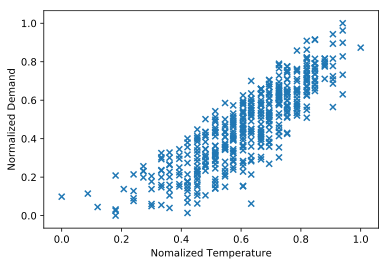

In [121]:
x = df_summer["Temp"].values
y = df_summer["Load"].values
x_nor = (x - min(x)) / (max(x) - min(x))
y_nor = (y - min(y)) / (max(y) - min(y))
plt.scatter(x_nor, y_nor, marker = 'x')
plt.xlabel("Nomalized Temperature")
plt.ylabel("Normalized Demand")

This look identical to the previous plot, of course, except that the units no longer correspond to traditional quantities like degrees Fahrenheit or gigawatts, but just some linear transformation of these units.

### Visualizing gradient descent

Now let's look at the gradient descent algorithm.  This will initialize $\theta_1$ and $\theta_2$ to zero and repeatedly update them according to the partial derivative rules.  We will use the step size $\alpha=1$, and print out the value of $\theta$ every 10 iterations.

In [134]:
theta = np.array([0., 0.])
alpha = 1.0
for t in range(101):
    if t % 10 == 0:
        print("Iteration {:3d}: ".format(t), theta)
    theta[0] -= alpha/len(x) * 2 * sum((theta[0] * x_nor + theta[1] - y_nor)*x_nor)
    theta[1] -= alpha/len(x) * 2 * sum((theta[0] * x_nor + theta[1] - y_nor) )
    

Iteration   0:  [ 0.  0.]
Iteration  10:  [ 0.84655268 -0.06193167]
Iteration  20:  [ 0.97827939 -0.13948752]
Iteration  30:  [ 1.0271543  -0.16826329]
Iteration  40:  [ 1.04528849 -0.17894004]
Iteration  50:  [ 1.05201687 -0.18290146]
Iteration  60:  [ 1.05451332 -0.18437128]
Iteration  70:  [ 1.05543958 -0.18491663]
Iteration  80:  [ 1.05578326 -0.18511898]
Iteration  90:  [ 1.05591077 -0.18519405]
Iteration 100:  [ 1.05595808 -0.18522191]


Let's visualize what this looks like in a couple different ways.  First, let's look at what our line looks like during different iterations of gradient descent.  For this purpose, we'll wrap the above in a simple function that takes `iters` iterations of gradient descent (note that we can of course get all these plots within a single run of gradient descent, but we'll just use multiple calls to this function for illustration purposes).

In [292]:
def gradient_descent(iters):
    theta = np.array([0., 0.])
    alpha = 1.0
    for t in range(iters):
        theta[0] -= alpha/len(x) * 2 * sum((theta[0] * x_nor + theta[1] - y_nor)*x_nor)
        theta[1] -= alpha/len(x) * 2 * sum((theta[0] * x_nor + theta[1] - y_nor) )
    return theta

def plot_fit(theta):
    plt.scatter(x_nor, y_nor, marker = 'x')
    plt.xlabel("Nomalized Temperature")
    plt.ylabel("Normalized Demand")
    xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())
    plt.plot(xlim, [theta[0]*xlim[0]+theta[1], theta[0]*xlim[1]+theta[1]], 'C1')
    plt.xlim(xlim)
    plt.ylim(ylim)
    

Clearly, after zero iterations of gradient descent, the function just is a straight line at zero (because the slope and intercept are both zero).

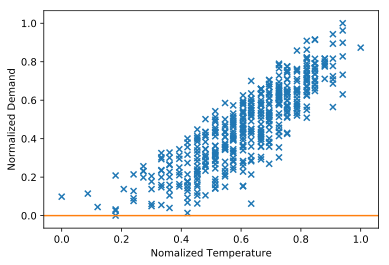

In [139]:
plot_fit(gradient_descent(0))

After just one iteration, we already start to see the line becoming a better fit.

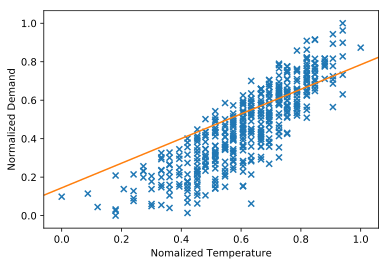

In [142]:
plot_fit(gradient_descent(1))

After five iterations the fit is better still.

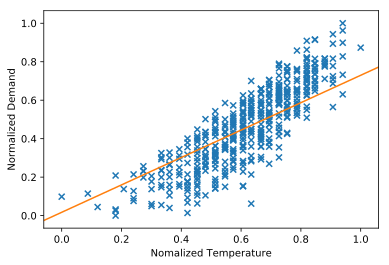

In [144]:
plot_fit(gradient_descent(5))

After 10 iterations.

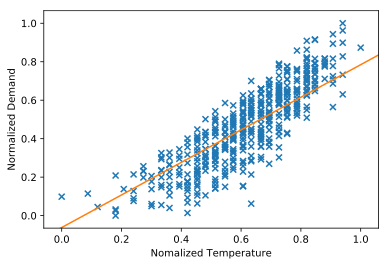

In [146]:
plot_fit(gradient_descent(10))

After 50 iterations.

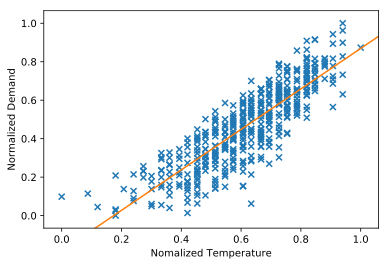

In [148]:
plot_fit(gradient_descent(50))

After 100 iterations

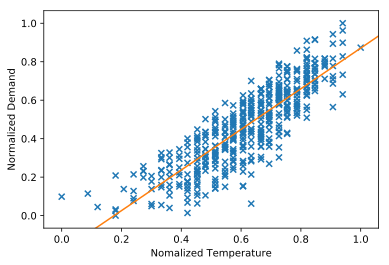

In [149]:
plot_fit(gradient_descent(100))

### Error versus iteration

We can also look at the average error versus iteration.

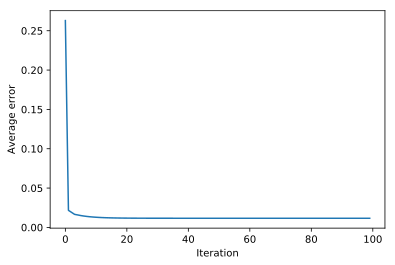

In [152]:
def gradient_descent_err(iters):
    err = []
    theta = np.array([0., 0.])
    alpha = 1.0
    for t in range(iters):
        err.append(np.mean((theta[0] * x_nor + theta[1] - y_nor)**2))
        theta[0] -= alpha/len(x) * 2 * sum((theta[0] * x_nor + theta[1] - y_nor)*x_nor)
        theta[1] -= alpha/len(x) * 2 * sum((theta[0] * x_nor + theta[1] - y_nor) )
    return np.array(err)

plt.plot(np.arange(0,100), gradient_descent_err(100))
plt.xlabel("Iteration")
plt.ylabel("Average error")

Note that because the error decreases so quickly, it's not that easy to see what happens here (which is a good thing, since it means the error effectively gets as low as it can be after 20 iterations or so).  If you want to see a more informative view, though, you can plot, on a log scale, of the error minus the "optimal error" (which you approximate by just running gradient descent a long time).

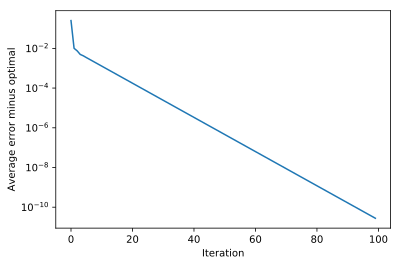

In [154]:
err = gradient_descent_err(1000)
plt.semilogy(err[:100] - err[-1])
plt.xlabel("Iteration")
plt.ylabel("Average error minus optimal")

As you can see, the error is decreasing _linearly_ with iteration number on the log scale; this means we will reach an optimal setting to numerical precision pretty quickly.  Although we won't cover it in any much more here, this is actually a property of the squared error, and things look a bit different if you consider other errors.

### Visualizing parameter updates

As a final visualization, let's look at what with the gradient updates in parameters space.  Here we're going to overlay "level sets" of the objective function (points at which the objective has equal value), the only point of which here is the fact that the optimal setting of these weights is in the "center" of the ellipses; essentially, the objective here is a 3D bowl-shaped function, with the lines showing its contours in 2D.

In [238]:
def gradient_descent_params(iters):
    thetas = []
    theta = np.array([0., 0.])
    alpha = 1.0
    for t in range(iters):
        thetas.append(theta.copy())
        theta[0] -= alpha/len(x) * 2 * sum((theta[0] * x_nor + theta[1] - y_nor)*x_nor)
        theta[1] -= alpha/len(x) * 2 * sum((theta[0] * x_nor + theta[1] - y_nor) )
    return np.array(thetas)

def err(theta):
    return np.mean((np.outer(x_nor, theta[:,0]) + theta[:,1] - y_nor[:,None])**2,axis=0)

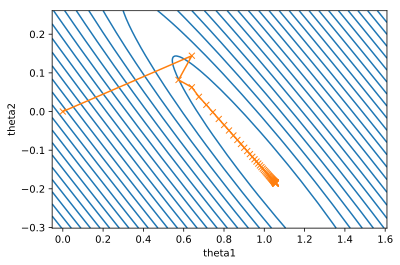

In [290]:
thetas = gradient_descent_params(100)
plt.plot(thetas[:,0], thetas[:,1])
xlim, ylim =(np.array(plt.gca().get_xlim()), np.array(plt.gca().get_ylim()))
xlim += np.array([0,0.5])
ylim += np.array([-0.1, 0.1])

XX,YY = np.meshgrid(np.linspace(xlim[0],xlim[1],200), np.linspace(ylim[0], ylim[1],200))
ZZ = err(np.hstack([np.ravel(XX)[:,None], np.ravel(YY)[:,None]])).reshape(XX.shape)
#V = np.logspace(np.log(np.min(ZZ)), np.log(np.max(ZZ)), 30)
V = np.linspace(np.sqrt(np.min(ZZ)), np.sqrt(np.max(ZZ)), 25)**2
plt.clf()
plt.contour(XX,YY,ZZ, V, colors=('C0',))
plt.plot(thetas[:,0], thetas[:,1], 'C1-x')
plt.xlabel("theta1")
plt.ylabel("theta2")

### Omitting normalization

What happens if we run this same process without first normalizing the data?  Let's look.

In [285]:
def gradient_descent_unnor(iters, alpha=1.0):
    theta = np.array([0., 0.])
    for t in range(iters):
        if t % (iters//10) == 0:
            print("Iteration {:3d}: ".format(t), theta)
        theta[0] -= alpha/len(x) * 2 * sum((theta[0] * x + theta[1] - y)*x)
        theta[1] -= alpha/len(x) * 2 * sum((theta[0] * x + theta[1] - y) )
    return theta

In [302]:
gradient_descent_unnor(100, alpha=1.0);

Iteration   0:  [ 0.  0.]
Iteration  10:  [  3.48201553e+39  -5.60453543e+41]
Iteration  20:  [  4.42067076e+80  -7.11536343e+82]
Iteration  30:  [  5.61236153e+121  -9.03346893e+123]
Iteration  40:  [  7.12529923e+162  -1.14686427e+165]
Iteration  50:  [  9.04608315e+203  -1.45602721e+206]
Iteration  60:  [  1.14846574e+245  -1.84853194e+247]
Iteration  70:  [  1.45806039e+286  -2.34684511e+288]
Iteration  80:  [ nan  nan]
Iteration  90:  [ nan  nan]


/Users/zkolter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in double_scalars
  
/Users/zkolter/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in add
  


Our parameters start blowing up and quickly cause numerical overflow.  The issue here is that `alpha` is too large for these unscaled values.  So let's lower it a bit.  The following was the lowest value I could find that didn't cause `alpha` to diverge.

In [303]:
gradient_descent_unnor(100, alpha=0.0001);

Iteration   0:  [ 0.  0.]
Iteration  10:  [ 0.02716586 -0.00011614]
Iteration  20:  [ 0.02716621 -0.00013093]
Iteration  30:  [ 0.0271664  -0.00014573]
Iteration  40:  [ 0.02716658 -0.00016052]
Iteration  50:  [ 0.02716676 -0.00017531]
Iteration  60:  [ 0.02716695 -0.00019011]
Iteration  70:  [ 0.02716713 -0.0002049 ]
Iteration  80:  [ 0.02716731 -0.00021969]
Iteration  90:  [ 0.0271675  -0.00023449]


The problem here is that we are nowhere _near_ converged to the solution.  Let's run it for one million iterations instead.

In [304]:
gradient_descent_unnor(1000000, alpha=0.0001);

Iteration   0:  [ 0.  0.]
Iteration 100000:  [ 0.028912   -0.14130278]
Iteration 200000:  [ 0.03050149 -0.26983678]
Iteration 300000:  [ 0.0319484  -0.38683977]
Iteration 400000:  [ 0.03326549 -0.49334622]
Iteration 500000:  [ 0.03446443 -0.59029778]
Iteration 600000:  [ 0.03555581 -0.67855165]
Iteration 700000:  [ 0.03654928 -0.75888811]
Iteration 800000:  [ 0.03745362 -0.83201744]
Iteration 900000:  [ 0.03827684 -0.89858621]


One million iterations, and our parameters are still changing quite a bit.  What's happening here, as mentioned above, is that we effectively need very different step sizes in the two parameters, because the scales are so different; what is more, it's actually the case that the best choice of parameters are also highly correlated, so that for instance, for a slight change in slope there is a _very_ different choice of intercept that is optimal, and vice versa.  Taken together, this means that it is very difficult for gradient descent to find a "good" direction by which to improve the function, and we essentially have to take extremely small steps that take a very long time for us to reach the optimal value.

### Getting the answer back in the original coordinates

Fortunately, we don't need to resort to solving the system in the original coordinates, we can simply solve on our normalized data and then find the corresponding equations for the original data.  Specifically, since our model gives the approximation
\begin{equation}
\begin{split}
\tilde{y} & \approx \tilde{x} \cdot \theta_1 + \theta_2\\
\Longrightarrow \;\; \frac{y-a}{b} & \approx \frac{x-c}{d} \cdot \theta_1 + \theta_2 \\
\Longrightarrow \;\; y-a & \approx (x-c) \cdot(b \theta_1/d) + b \theta_2 \\
\Longrightarrow \;\; y & \approx x \cdot (b \theta_1/d) + b \theta_2 + a - c b \theta_1/d\\
\Longrightarrow \;\; y & \approx x \cdot \hat{\theta}_1 + \hat{\theta}_2\\
\end{split}
\end{equation}
where
\begin{equation}
a = \min_i y^{(i)}, \;\; b = \max_i y^{(i)} - \min_i y^{(i)}, \;\; c = \min_i x^{(i)}, \;\; d = \max_i x^{(i)} - \min_i x^{(i)}, 
\end{equation}
and where we define
\begin{equation}
\begin{split}
\hat{\theta}_1 & = b \theta_1/d \\
\hat{\theta}_2 & = b \theta_2 + a - c \cdot(b \theta_1/d).
\end{split}
\end{equation}
That might seem like a lot, but all it's saying is that there is an easy formula to convert between the solution we get for the normalized data and the unnormalized data.


In [ ]:
theta = gradient_descent(100)
a, b, c, d = min(y), max(y) - min(y), min(x), max(x) - min(x)
theta_hat = np.array([b * theta[0] / d, b*theta[1] + a - c*b*theta[0]/d])

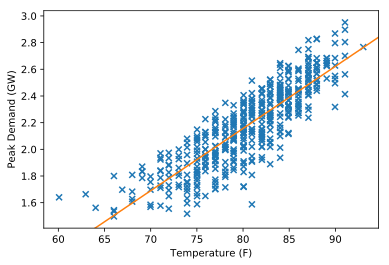

In [300]:
plt.scatter(df_summer["Temp"], df_summer["Load"], marker='x')
xlim, ylim =(plt.gca().get_xlim(), plt.gca().get_ylim())
plt.plot(xlim, [theta_hat[0]*xlim[0]+theta_hat[1], theta_hat[0]*xlim[1]+theta_hat[1]], 'C1')
plt.xlim(xlim)
plt.ylim(ylim)
plt.xlabel("Temperature (F)")
plt.ylabel("Peak Demand (GW)")

The plot of course looks identical to the one we had one the normalized data.  But now we can use the model to make predictions on new data point in terms of the original units, without normalization.  

## Machine learning in general

There was a lot to this example, including collecting the data, deriving the gradient, running the gradient descent algorithm, and considering different aspects of normalization.  We put them before the "general" discussion on ML because these topics are ones that you are absolutely going to encounter in practice (and least the understanding of the models, data normalization, etc, even if you don't end up writing your own gradient descent code).  But the nice aspects now, is that we can introduce virtually all the main concepts the machine learning, hopefully made substantially more concrete by the example.

(to be continued)